<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/2DCNN_LSTM_081300MARipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca_trade_api

     |████████████████████████████████| 1.3 MB 22.3 MB/s 
     |████████████████████████████████| 111 kB 61.5 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
     |████████████████████████████████| 273 kB 68.7 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 86.9 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [3]:
random_seed = 182
torch.manual_seed(random_seed)

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [6]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 2, 18)
train_end = date(2020, 3, 29)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "CORN" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 60 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 1135
Number of days of Validation Data 400
Number of days of Holdout Test Data 309


In [7]:
train_raw[0:300]

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2016-12-20 09:25:00-05:00,2016-12-20 09:25:00-05:00,18.8400,18.8400,18.8400,18.8400,390,18.840000
2016-12-20 09:30:00-05:00,2016-12-20 09:30:00-05:00,18.8500,18.9000,18.8500,18.8900,10913,18.859530
2016-12-20 09:35:00-05:00,2016-12-20 09:35:00-05:00,18.8300,18.8583,18.8300,18.8300,8414,18.836839
2016-12-20 09:40:00-05:00,2016-12-20 09:40:00-05:00,18.8300,18.8450,18.8300,18.8400,34050,18.834351
2016-12-20 09:45:00-05:00,2016-12-20 09:45:00-05:00,18.8483,18.8500,18.8400,18.8500,950,18.844863
...,...,...,...,...,...,...,...
2016-12-29 13:20:00-05:00,2016-12-29 13:20:00-05:00,18.6900,18.6900,18.6900,18.6900,100,18.690000
2016-12-29 13:25:00-05:00,2016-12-29 13:25:00-05:00,18.6999,18.6999,18.6999,18.6999,150,18.699900
2016-12-29 13:35:00-05:00,2016-12-29 13:35:00-05:00,18.6814,18.6814,18.6814,18.6814,460,18.681400


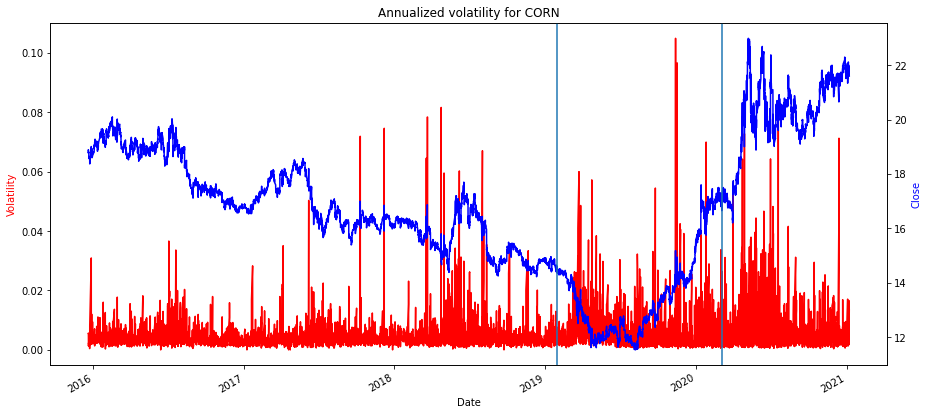

In [8]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [105]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

# OLDER CODE WITHOUT OVERLAP OF LABELING
# def blockshaped(arr, nrows, ncols):
#     """
#     Return an array of shape (n, nrows, ncols) where
#     n * nrows * ncols = arr.size

#     If arr is a 2D array, the returned array should look like n subblocks with
#     each subblock preserving the "physical" layout of arr.
#     """
#     h, w = arr.shape
#     assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
#     assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
#     return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
#                .swapaxes(1,2)
#                .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)


def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 0):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 0)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 0)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 0)

# X_train_pre_final = blockshaped(train_array, 24, 5)
# X_val_pre_final = blockshaped(val_array, 24, 5)
# X_test_pre_final = blockshaped(test_array, 24, 5)

In [106]:
np.set_printoptions(edgeitems=10,linewidth=580)
X_train_pre_final[1]

array([[  18.8   ,   18.79  ,   18.78  ,   18.7999,   18.78  ,   18.782 ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.8   ,   18.8   ,   18.7903,   18.79  ,   18.79  ,   18.8   ,   18.8   ],
       [  18.8   ,   18.79  ,   18.78  ,   18.7999,   18.78  ,   18.782 ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.8   ,   18.8   ,   18.7903,   18.79  ,   18.79  ,   18.8   ,   18.8   ],
       [  18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.77  ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.7902,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.8   ,   18.8   ,   18.79  ,   18.79  ,   18.79  ,   18.8   ,   18.8   ],
       [  18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.77  ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.7902,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78 

In [107]:
train_tonp[24:48]

,Open,High,Low,Close,Volume
Time,,,,,
2016-12-20 11:30:00-05:00,18.8000,18.8000,18.8000,18.8000,2400.0
2016-12-20 11:35:00-05:00,18.7900,18.7900,18.7900,18.7900,600.0
2016-12-20 11:40:00-05:00,18.7800,18.7800,18.7800,18.7800,100.0
2016-12-20 11:45:00-05:00,18.7999,18.7999,18.7800,18.7800,2100.0
2016-12-20 11:50:00-05:00,18.7800,18.7800,18.7800,18.7800,0.0
2016-12-20 11:55:00-05:00,18.7820,18.7820,18.7700,18.7700,1700.0
2016-12-20 12:00:00-05:00,18.7700,18.7700,18.7700,18.7700,0.0
2016-12-20 12:05:00-05:00,18.8000,18.8000,18.8000,18.8000,100.0
2016-12-20 12:10:00-05:00,18.8000,18.8000,18.8000,18.8000,0.0


In [108]:
X_train_pre_final[1]

array([[  18.8   ,   18.79  ,   18.78  ,   18.7999,   18.78  ,   18.782 ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.8   ,   18.8   ,   18.7903,   18.79  ,   18.79  ,   18.8   ,   18.8   ],
       [  18.8   ,   18.79  ,   18.78  ,   18.7999,   18.78  ,   18.782 ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.8   ,   18.8   ,   18.7903,   18.79  ,   18.79  ,   18.8   ,   18.8   ],
       [  18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.77  ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.7902,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.78  ,   18.8   ,   18.8   ,   18.79  ,   18.79  ,   18.79  ,   18.8   ,   18.8   ],
       [  18.8   ,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.77  ,   18.77  ,   18.8   ,   18.8   ,   18.8   ,   18.7902,   18.79  ,   18.78  ,   18.78  ,   18.78  ,   18.78 

In [109]:
# create target from OHLC and Volume Data
###### THIS IS FOR 3 CLASS FROM PAPER ########
# def buildTargets(obs_array,  
#                  alph = .55, 
#                  volity_int = 10):

#   """ 
#   This function will take a complete set of train, val, and test 
#   data and return the targets. Volitility will be calculated over 
#   the 24 5min incriments. The Target shift is looking at 2 hours 
#   shift from current time

#   shift_2hour = The amount of time the data interval take to equal 2 hours 
#                 (i.e. 5 min data interval is equal to 24)
#   alph = The alpha value for calculating the shift in price
#   volity_int = the number of incriments used to calculate volitility 
#   """

#   target_close_list =[]

#   for arr in obs_array:
#     target_close_list.append(arr[3][-1])
  
#   target_close_df = pd.DataFrame()
#   target_close_df["Close"] = target_close_list

#   target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

#   # print(len(volatility), len(target_close_df["Close"]))

  
#   targets = [0] * len(target_close_df.Close)

#   targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph * target_close_df["Volitility"])), 
#            2, targets)
  
#   targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph * target_close_df["Volitility"])), 
#            1, targets)

#   return targets


#####DISREGUARD THE VOLITLITY######
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()
  
  targets = [0] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph)), 
           2, targets)
  
  targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph)), 
           1, targets)

  return targets

  #####Binary Class######
# def buildTargets(obs_array,  
#                  alph = .55, 
#                  volity_int = 10):

#   """ 
#   This function will take a complete set of train, val, and test 
#   data and return the targets. Volitility will be calculated over 
#   the 24 5min incriments. The Target shift is looking at 2 hours 
#   shift from current time

#   shift_2hour = The amount of time the data interval take to equal 2 hours 
#                 (i.e. 5 min data interval is equal to 24)
#   alph = The alpha value for calculating the shift in price
#   volity_int = the number of incriments used to calculate volitility 
#   """

#   target_close_list =[]

#   for arr in obs_array:
#     target_close_list.append(arr[3][-1])
  
#   target_close_df = pd.DataFrame()
#   target_close_df["Close"] = target_close_list

#   target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

#   # print(len(volatility), len(target_close_df["Close"]))

  
#   targets = [0] * len(target_close_df.Close)

#   targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph)), 
#            1, targets)

#   return targets

In [110]:
volity_val = 10
alph = .0015
y_train_pre_final = buildTargets(X_train_pre_final, alph=alph,  volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, alph=alph, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, alph=alph, volity_int = volity_val)

In [111]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "down": 0,
        "flat": 0,
    }
    
    for i in obj:
        if i == 2: 
            count_dict['up'] += 1
        elif i == 1: 
            count_dict['down'] += 1
        elif i == 0: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

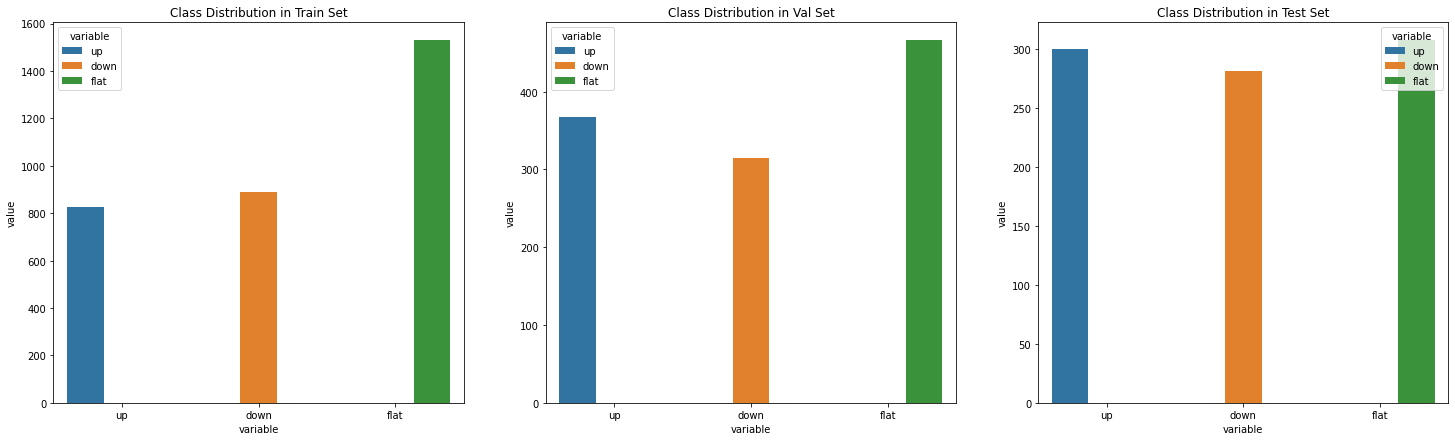

In [112]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [113]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### EXECUTE IF YOU WANT FULL DATA, AND NOT REMOVING END OF DAT###########
# y_train = np.array(y_train_pre_final)
# y_val = np.array(y_val_pre_final)
# y_test = np.array(y_test_pre_final)

# X_train = X_train_pre_final
# X_val = X_val_pre_final
# X_test = X_test_pre_final

In [114]:
# Check it arrays are made correctly
train[12:48]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2016-12-20 10:30:00-05:00,18.8600,18.8600,18.8600,18.8600,500.0,18.860000
2016-12-20 10:35:00-05:00,18.8400,18.8400,18.8300,18.8300,26000.0,18.839275
2016-12-20 10:40:00-05:00,18.8200,18.8201,18.8100,18.8100,700.0,18.815743
2016-12-20 10:45:00-05:00,18.8100,18.8250,18.8000,18.8000,4991.0,18.814949
2016-12-20 10:50:00-05:00,18.8000,18.8000,18.8000,18.8000,0.0,0.000000
2016-12-20 10:55:00-05:00,18.8000,18.8000,18.8000,18.8000,0.0,0.000000
2016-12-20 11:00:00-05:00,18.8355,18.8355,18.8355,18.8355,130.0,18.835500
2016-12-20 11:05:00-05:00,18.8308,18.8386,18.8308,18.8386,525.0,18.833771
2016-12-20 11:10:00-05:00,18.8200,18.8215,18.8200,18.8201,1225.0,18.820296


In [115]:
np.set_printoptions(threshold=200)
y_train_pre_final[50:75]

array([0, 1, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0])

In [116]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    

Text(0.5, 1.0, 'Class Distribution in Test Set')

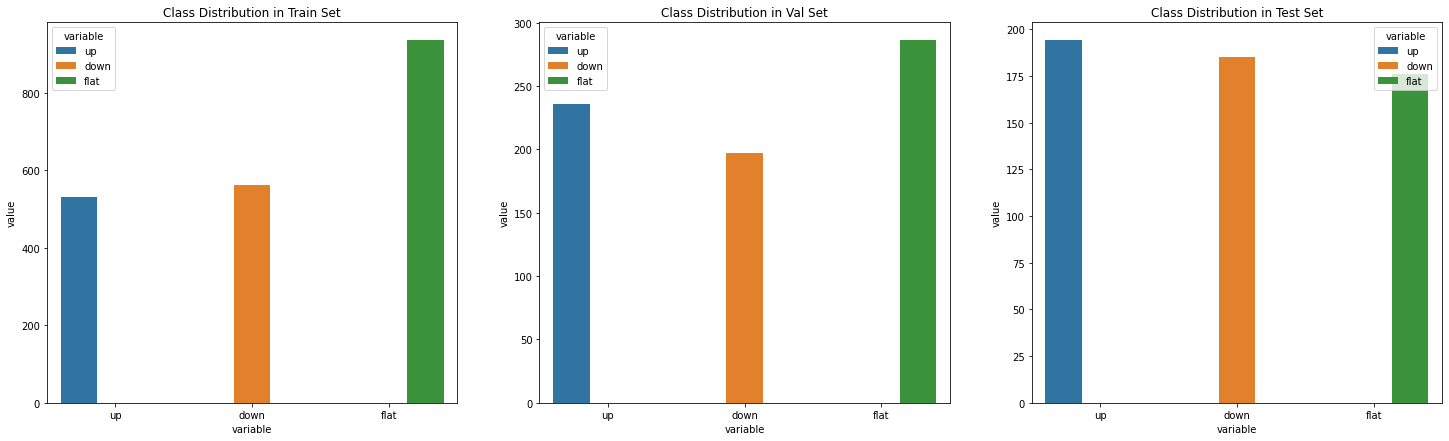

In [117]:
vbfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

# SET UP FOR LTSM 2D CNN

In [118]:
X_full = np.concatenate((X_train, X_val, X_test))
y_full = np.concatenate((y_train, y_val, y_test))


X_train, X_next, y_train, y_next = train_test_split(X_full, y_full, test_size=0.4, random_state=82)
X_val, X_test, y_val, y_test = train_test_split(X_next, y_next, test_size=0.3, random_state=101)

In [119]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten, Dense, Activation
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Input, Model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam

In [120]:
X_train.shape

(1981, 5, 24)

In [123]:
X_train_lstm = np.array([])

for arr in X_train:

  if X_train_lstm.size == 0:
    int_array = np.array(np.hsplit(arr, 4)).reshape(1, 4, 5, 6, 1)
    X_train_lstm = int_array

  else:
    int_array = np.array(np.hsplit(arr, 4)).reshape(1, 4, 5, 6, 1)
    X_train_lstm = np.concatenate((X_train_lstm, int_array))


X_val_lstm= np.array([])

for arr in X_val:

  if X_val_lstm.size == 0:
    int_array = np.array(np.hsplit(arr, 4)).reshape(1, 4, 5, 6, 1)
    X_val_lstm = int_array

  else:
    int_array = np.array(np.hsplit(arr, 4)).reshape(1, 4, 5, 6, 1)
    X_val_lstm = np.concatenate((X_val_lstm, int_array))

X_test_lstm = np.array([])

for arr in X_test:

  if X_test_lstm.size == 0:
    int_array = np.array(np.hsplit(arr, 4)).reshape(1, 4, 5, 6, 1)
    X_test_lstm = int_array

  else:
    int_array = np.array(np.hsplit(arr, 4)).reshape(1, 4, 5, 6, 1)
    X_test_lstm = np.concatenate((X_test_lstm, int_array))

In [124]:
y_train_final = to_categorical(y_train, 3)
y_val_final = to_categorical(y_val, 3)
y_test_final = to_categorical(y_test, 3)

print(f'X Train Length {X_train_lstm.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val_lstm.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test_lstm.shape}, y Test Label Length {y_test.shape}')

X Train Length (1981, 4, 5, 6, 1), y Train Label Length (1981,)
X Val Length (925, 4, 5, 6, 1), y Val Label Length (925,)
X Test Length (397, 4, 5, 6, 1), y Test Label Length (397,)


In [146]:
from sklearn import metrics
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(X_train_lstm.shape[1:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 3),
    strides=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 1),
    strides=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
# x = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 1),
#     strides=(1, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
x = layers.Conv2D(
    filters=128, kernel_size=(1, 3), strides=(1, 3), activation="relu", padding="same"
)(x)
x = layers.Flatten()(x)
x = layers.Dense(1000,activation="relu")(x)
x = layers.Dense(500,activation="relu")(x)
x = layers.Dense(3,activation="softmax")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 4, 5, 6, 1)]      0         
                                                                 
 conv_lstm2d_43 (ConvLSTM2D)  (None, 4, 5, 6, 32)      105728    
                                                                 
 batch_normalization_14 (Bat  (None, 4, 5, 6, 32)      128       
 chNormalization)                                                
                                                                 
 conv_lstm2d_44 (ConvLSTM2D)  (None, 4, 5, 6, 64)      73984     
                                                                 
 conv_lstm2d_45 (ConvLSTM2D)  (None, 4, 5, 6, 64)      164096    
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 5, 2, 128)      24704     
                                                          

In [147]:
model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 12

# Fit the model to the training data.
hist = model.fit(
    X_train_lstm,
    y_train_final,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_lstm, y_val_final),
    callbacks=[reduce_lr, early_stopping],
    # class_weight={0:1, 1:1.25, 2:1.25},
)
model_name = f'cdt2d_model_{date}'

Epoch 1/100
166/166 [==============================] - 20s 77ms/step - loss: 1.0876 - accuracy: 0.4149 - val_loss: 1.0776 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 2/100
166/166 [==============================] - 12s 74ms/step - loss: 1.0842 - accuracy: 0.4195 - val_loss: 1.0782 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 3/100
166/166 [==============================] - 12s 75ms/step - loss: 1.0835 - accuracy: 0.4190 - val_loss: 1.0791 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 4/100
166/166 [==============================] - 12s 72ms/step - loss: 1.0835 - accuracy: 0.4185 - val_loss: 1.0725 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 5/100
166/166 [==============================] - 12s 72ms/step - loss: 1.0801 - accuracy: 0.4195 - val_loss: 1.0720 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 6/100
166/166 [==============================] - 12s 73ms/step - loss: 1.0789 - accuracy: 0.4175 - val_loss: 1.0713 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 7/100
166/166 [==============================]

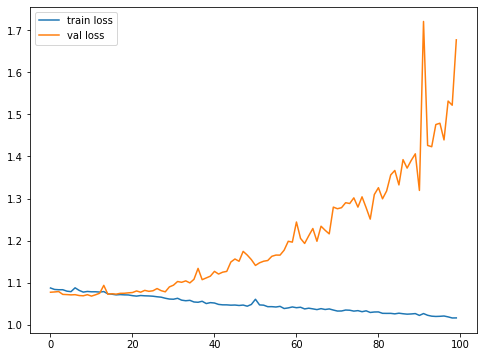

In [148]:
  plt.figure(figsize=(8, 6))
  plt.plot(hist.history['loss'], label='train loss')
  plt.plot(hist.history['val_loss'], label='val loss')
  plt.legend()
  #plt.savefig(f'plots/LossVal_loss_{date}.png')
  plt.show()

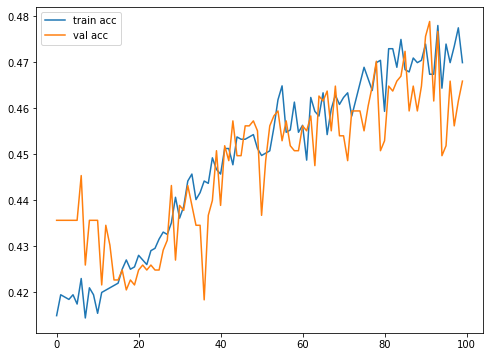

In [149]:
plt.figure(figsize=(8, 6))
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
#plt.savefig(f'plots/AccVal_acc_{date}.png')
plt.show()

Test set accuracy is 0.436
For class 0, recall is 0.742
For class 1, recall is 0.108
For class 2, recall is 0.342
Accuracy is 0.436
Weight CDT F Score: 0.5462475045607147


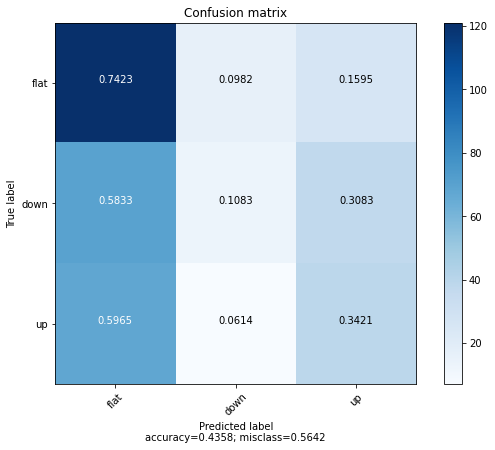

              precision    recall  f1-score   support

        flat     0.4672    0.7423    0.5735       163
        down     0.3611    0.1083    0.1667       120
          up     0.3824    0.3421    0.3611       114

    accuracy                         0.4358       397
   macro avg     0.4035    0.3976    0.3671       397
weighted avg     0.4108    0.4358    0.3895       397



In [153]:
y_pred = model.predict(X_test_lstm)


# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_final, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1,2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Accuracy is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    # plt.savefig(f'plots/Confusion_{date}.png')
    plt.show()

def calculate_weighted_f_score(y_true, y_pred):
    test_preds = np.argmax(y_pred, axis=-1)
    Ntu = sum((test_preds == 2) & (y_true == 2))
    Ntd = sum((test_preds == 1) & (y_true == 1))
    Ntf = sum((test_preds == 0) & (y_true == 0))
    Ewutd = sum((test_preds == 2) & (y_true == 1))
    Ewdtu = sum((test_preds == 1) & (y_true == 2))
    Ewutf = sum((test_preds == 2) & (y_true == 0))
    Ewdtf = sum((test_preds == 1) & (y_true == 0))
    Ewftu = sum((test_preds == 0) & (y_true == 2))
    Ewftd = sum((test_preds == 0) & (y_true == 1))

    beta_1 = 0.5
    beta_2 = 0.125
    beta_3 = 0.125

    Ntp = Ntu + Ntd + beta_3**2 * Ntf
    E1 = Ewutd + Ewdtu
    E2 = Ewutf + Ewdtf
    E3 = Ewftu + Ewftd

    F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
    return  F


print(f'Weight CDT F Score: {calculate_weighted_f_score(y_true, y_pred)}')

nb_classes = 3

# Confusion matrix
conf_mat=confusion_matrix(y_true, np.argmax(y_pred, axis=-1))

plot_confusion_matrix(conf_mat, ["flat", "down","up"])

precision_score(y_true, np.argmax(y_pred, axis=-1), average='weighted')

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=["flat", "down", "up"], digits=4))


# 2D LSTM

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Input, Model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam

In [25]:
###### ONLY EXECUTE FOR KERAS 2D CNN #####

X_train_2d = X_train.reshape(X_train.shape[0], 
                             1,
                          X_train.shape[1], 
                          X_train.shape[2],
                          1
                          )
X_val_2d = X_val.reshape(X_val.shape[0],
                         1,
                          X_val.shape[1], 
                          X_val.shape[2],
                         1
                          )
X_test_2d = X_test.reshape(X_test.shape[0],
                           1,
                          X_test.shape[1], 
                          X_test.shape[2],
                           1
                          )

from tensorflow.keras.utils import to_categorical

y_train_final = to_categorical(y_train, 3)
y_val_final = to_categorical(y_val, 3)
y_test_final = to_categorical(y_test, 3)

print(f'X Train Length {X_train_2d.shape}, y Train Label Length {y_train_final.shape}')
print(f'X Val Length {X_val_2d.shape}, y Val Label Length {y_val_final.shape}')
print(f'X Test Length {X_test_2d.shape}, y Test Label Length {y_test_final.shape}')

X Train Length (3248, 1, 5, 24, 1), y Train Label Length (3248, 3)
X Val Length (1148, 1, 5, 24, 1), y Val Label Length (1148, 3)
X Test Length (884, 1, 5, 24, 1), y Test Label Length (884, 3)


In [42]:
np.hsplit(X_train_2d[1][0], 4)[0].shape

(5, 6, 1)

In [26]:
for i in range(2):
  print(X_train_2d[i])

[[[[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]]]
[[[[0.00000000e+00]
   [0.000

In [177]:
from sklearn import metrics
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(X_train_2d.shape[1:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(1, 3),
    strides=(1, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 3),
    strides=(1, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 2),
    strides=(1, 2),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv2D(
    filters=128, kernel_size=(1, 2), strides=(1, 1), activation="sigmoid", padding="same"
)(x)
x = layers.Flatten()(x)
x = layers.Dense(1000,activation="relu")(x)
x = layers.Dense(500,activation="relu")(x)
x = layers.Dense(3,activation="softmax")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)


model.summary()

model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 5, 24, 1)]     0         
                                                                 
 conv_lstm2d_29 (ConvLSTM2D)  (None, 1, 5, 8, 32)      12800     
                                                                 
 batch_normalization_7 (Batc  (None, 1, 5, 8, 32)      128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_30 (ConvLSTM2D)  (None, 1, 5, 3, 64)      73984     
                                                                 
 conv_lstm2d_31 (ConvLSTM2D)  (None, 1, 5, 2, 64)      65792     
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 5, 2, 128)      16512     
                                                           

In [179]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 250
batch_size = 12

# Fit the model to the training data.
hist = model.fit(
    X_train_2d,
    y_train_final,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_2d, y_val_final),
    # callbacks=[reduce_lr], #, early_stopping,],
    # class_weight={0:1, 1:1.25, 2:1.25},
)

Epoch 1/250
270/270 [==============================] - 4s 15ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy: 0.4030
Epoch 2/250
270/270 [==============================] - 4s 13ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy: 0.4030
Epoch 3/250
270/270 [==============================] - 4s 13ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy: 0.4030
Epoch 4/250
270/270 [==============================] - 4s 13ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy: 0.4030
Epoch 5/250
270/270 [==============================] - 4s 13ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy: 0.4030
Epoch 6/250
270/270 [==============================] - 4s 13ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy: 0.4030
Epoch 7/250
270/270 [==============================] - 4s 13ms/step - loss: 1.2260 - accuracy: 0.4719 - val_loss: 1.0908 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_val_pred = model.predict(X_test_2d)

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_val_pred, axis=1)
y_true = np.argmax(y_test_final, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0, 1, 2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Accuracy is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 3

# Confusion matrix
conf_mat=confusion_matrix(y_true, np.argmax(y_val_pred, axis=-1))
plot_confusion_matrix(conf_mat, [0,1,2])

from sklearn.metrics import precision_score

precision_score(y_true, np.argmax(y_val_pred, axis=-1), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_val_pred, axis=-1), target_names=["flat", "down", "up"], digits=4))

In [ ]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  Ntu = sum((test_preds == 2) & (y_true == 2))
  Ntd = sum((test_preds == 1) & (y_true == 1))
  Ntf = sum((test_preds == 0) & (y_true == 0))
  Ewutd = sum((test_preds == 2) & (y_true == 1))
  Ewdtu = sum((test_preds == 1) & (y_true == 2))
  Ewutf = sum((test_preds == 2) & (y_true == 0))
  Ewdtf = sum((test_preds == 1) & (y_true == 0))
  Ewftu = sum((test_preds == 0) & (y_true == 2))
  Ewftd = sum((test_preds == 0) & (y_true == 1))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

print(f'Weight CDT F Score: {calculate_weighted_f_score(y_true, y_val_pred)}')